Let's import our packages

In [103]:
import pandas as pd
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import statsmodels.api as sm
import seaborn as sns

plt.style.use('fivethirtyeight') # Use five thirty eight plotting style
plt.rcParams['axes.facecolor'] = 'white' # Set plot backgrounds to white

Download our dataset with responses and predictors.

In [104]:
predPath = r"C:\Users\asher\Documents\GitHub\data602-finalproject\predictorsDF.csv"
predictorsDF = pd.read_csv(predPath, index_col = 0)
predictorsDF["logPrecip"] = np.log(predictorsDF["Precip"]+1) # Add a log(precipitation) column

Indx = [] # Index to hold dates
for i in range(len(predictorsDF)): 
    # Convert strings containing dates (eg '2012-10-03') to date objects
    Indx.append(datetime.strptime(predictorsDF.index[i], '%Y-%m-%d').date())
predictorsDF.index = Indx

In [5]:
predictorsDF.columns

Index(['Date', 'BGT', 'Broad', 'Elliot', 'Fremont', 'MTS', 'NW58', 'Second',
       'Spokane', 'Thirty', 'TwoSix', 'Sunlight', 'Weekend', 'isMay', 'TempHi',
       'TempAvg', 'TempLow', 'DewHigh', 'DewAvg', 'DewLow', 'HumidHi',
       'HumidAvg', 'HumidLow', 'PressHigh', 'PressAvg', 'PressLow', 'VisHigh',
       'VisAvg', 'VisLow', 'WindAvg', 'WindLow', 'WindHigh', 'Precip',
       'Events', 'Holiday', 'BusinessDay', 'WeekNumber', 'Friday'],
      dtype='object')

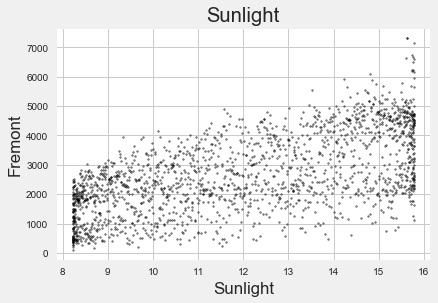

In [97]:
# Create data
predictor = "Sunlight"
counter = "Fremont"
x = predictorsDF[predictor]
y = predictorsDF["Fremont"]
colors = (0,0,0)
area = np.pi*1
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title(predictor)
plt.xlabel(predictor)
plt.ylabel(counter)
plt.show()

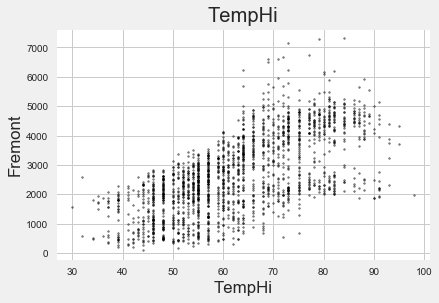

In [96]:
# Create data
predictor = "TempHi"
counter = "Fremont"
x = predictorsDF[predictor]
y = predictorsDF["Fremont"]
colors = (0,0,0)
area = np.pi*1
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title(predictor)
plt.xlabel(predictor)
plt.ylabel(counter)
plt.show()

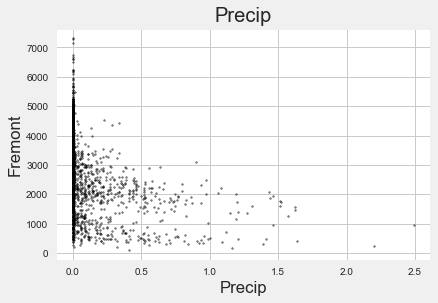

In [100]:
# Create data
predictor = "Precip"
counter = "Fremont"
x = predictorsDF[predictor]
y = predictorsDF["Fremont"]
colors = (0,0,0)
area = np.pi*1
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title(predictor)
plt.xlabel(predictor)
plt.ylabel(counter)
plt.show()

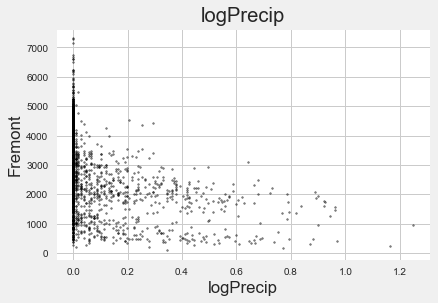

In [99]:
# Create data
predictor = "logPrecip"
counter = "Fremont"
x = predictorsDF[predictor]
y = predictorsDF["Fremont"]
colors = (0,0,0)
area = np.pi*1
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title(predictor)
plt.xlabel(predictor)
plt.ylabel(counter)
plt.show()

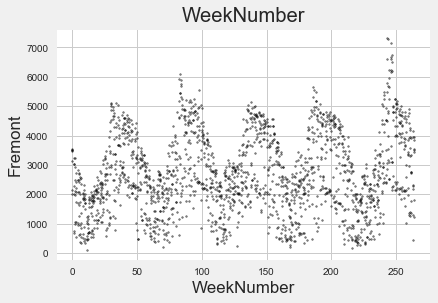

In [98]:
# Create data
predictor = "WeekNumber"
counter = "Fremont"
x = predictorsDF[predictor]
y = predictorsDF["Fremont"]
colors = (0,0,0)
area = np.pi*1
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title(predictor)
plt.xlabel(predictor)
plt.ylabel(counter)
plt.show()

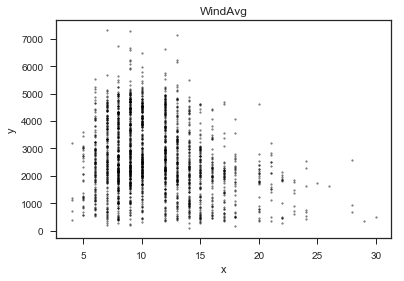

In [36]:
# Create data
predictor = "WindAvg"
x = predictorsDF[predictor]
y = predictorsDF["Fremont"]
colors = (0,0,0)
area = np.pi*1
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title(predictor)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

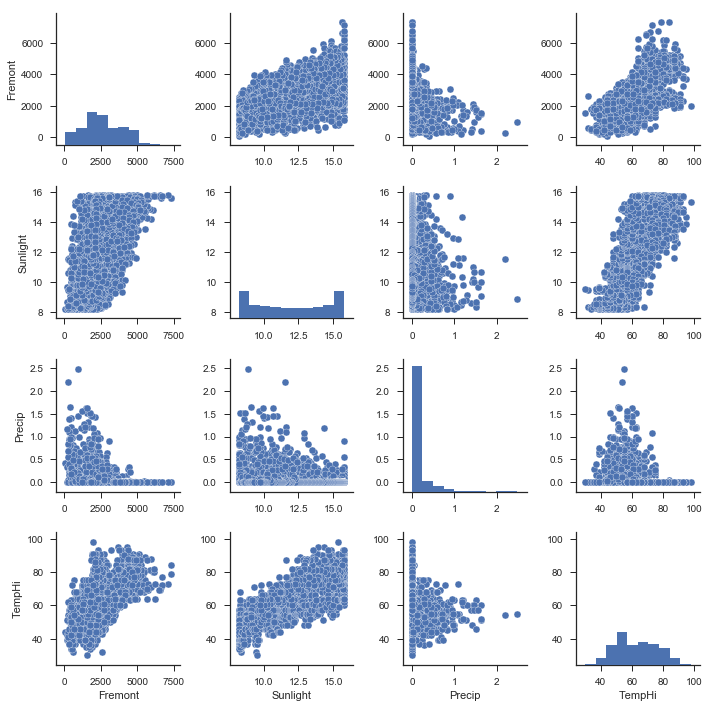

In [38]:
sns.set(style = "ticks")
df = predictorsDF.loc[:,["Fremont", "Sunlight", "Precip", "TempHi"]]
sns.pairplot(df)
plt.show()

In [70]:
predictorsDF.columns # Business Day is any weekday that is not a legal holiday

Index(['Date', 'BGT', 'Broad', 'Elliot', 'Fremont', 'MTS', 'NW58', 'Second',
       'Spokane', 'Thirty', 'TwoSix', 'Sunlight', 'Weekend', 'isMay', 'TempHi',
       'TempAvg', 'TempLow', 'DewHigh', 'DewAvg', 'DewLow', 'HumidHi',
       'HumidAvg', 'HumidLow', 'PressHigh', 'PressAvg', 'PressLow', 'VisHigh',
       'VisAvg', 'VisLow', 'WindAvg', 'WindLow', 'WindHigh', 'Precip',
       'Events', 'Holiday', 'BusinessDay', 'WeekNumber', 'Friday',
       'logPrecip'],
      dtype='object')

In [141]:
# Start dataset at 2014, as most counters did not begin
post2014 = predictorsDF.loc[datetime(2014, 1, 1).date():, :]

In [287]:
fit1 = smf.ols('Fremont ~ Sunlight + logPrecip + TempHi + BusinessDay + WeekNumber', 
               data=predictorsDF).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:                Fremont   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     1775.
Date:                Sat, 25 Nov 2017   Prob (F-statistic):               0.00
Time:                        08:50:04   Log-Likelihood:                -14342.
No. Observations:                1855   AIC:                         2.870e+04
Df Residuals:                    1849   BIC:                         2.873e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2287.9766    

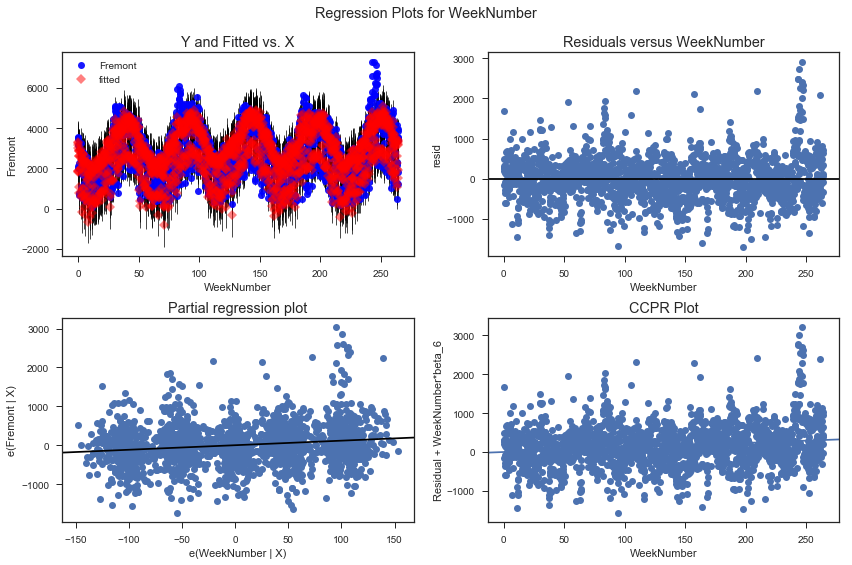

In [85]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(fit1, "WeekNumber", fig=fig)
plt.show()

In [171]:
# Create a dataframe
lastmonth = (predictorsDF.shape[0]-31)
sansOct2017 = predictorsDF.iloc[0:lastmonth, :]
fitSansOct2017 = smf.ols('Fremont ~ Sunlight + logPrecip + TempHi + BusinessDay + WeekNumber', 
               data=sansOct2017).fit()
print(fitSansOct2017.summary())

                            OLS Regression Results                            
Dep. Variable:                Fremont   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     1759.
Date:                Fri, 24 Nov 2017   Prob (F-statistic):               0.00
Time:                        17:00:51   Log-Likelihood:                -14100.
No. Observations:                1824   AIC:                         2.821e+04
Df Residuals:                    1818   BIC:                         2.824e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2289.6168    

In [173]:
regPred = fitSansOct2017.predict(predictorsDF.iloc[lastmonth: , ])
print(regPred)

2017-10-01    1706.974385
2017-10-02    3388.126390
2017-10-03    3581.513658
2017-10-04    3575.873784
2017-10-05    3569.341393
2017-10-06    3402.867669
2017-10-07    1552.633895
2017-10-08    1662.167531
2017-10-09    1735.673422
2017-10-10    3079.965940
2017-10-11    3091.499661
2017-10-12    2595.584140
2017-10-13    3044.735895
2017-10-14    1424.594563
2017-10-15    1618.193377
2017-10-16    3299.593031
2017-10-17    3129.657398
2017-10-18    2191.543736
2017-10-19    2312.850433
2017-10-20    2736.649929
2017-10-21    1192.420042
2017-10-22    1435.574919
2017-10-23    3297.093219
2017-10-24    3371.010233
2017-10-25    3365.894439
2017-10-26    3119.982681
2017-10-27    3274.001346
2017-10-28    1700.357549
2017-10-29    1334.614810
2017-10-30    3216.481865
2017-10-31    3090.771226
dtype: float64


In [87]:
from fbprophet import Prophet

Index([2012-10-03, 2012-10-04, 2012-10-05, 2012-10-06, 2012-10-07, 2012-10-08,
       2012-10-09, 2012-10-10, 2012-10-11, 2012-10-12,
       ...
       2017-09-21, 2017-09-22, 2017-09-23, 2017-09-24, 2017-09-25, 2017-09-26,
       2017-09-27, 2017-09-28, 2017-09-29, 2017-09-30],
      dtype='object', length=1824)

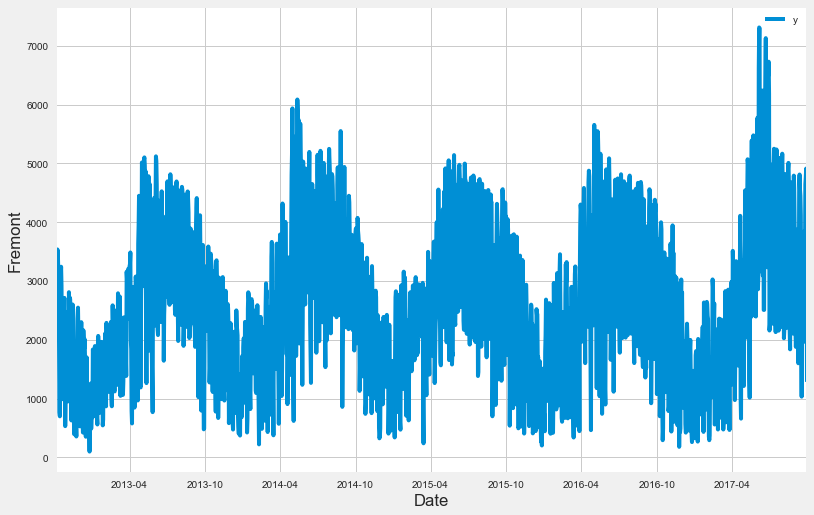

In [147]:
lastmonth = (predictorsDF.shape[0]-31)
df = pd.DataFrame(data = {'ds': predictorsDF.index[0:lastmonth], # Exclude last month for comparison
                          'y': predictorsDF["Fremont"][0:lastmonth]})
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Fremont')
ax.set_xlabel('Date')

plt.show()

In [215]:
my_model = Prophet(interval_width=0.95, daily_seasonality=True)
my_model.fit(df)

# Create datestamps for dates to be forecasted
future_dates = my_model.make_future_dataframe(periods=31, freq='D')
future_dates.tail()

FBPred = my_model.predict(future_dates)

FBPred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][lastmonth:]

,ds,yhat,yhat_lower,yhat_upper
1824,2017-10-01,2016.205388,646.455007,3306.581791
1825,2017-10-02,3641.390246,2419.871113,4935.214013
1826,2017-10-03,3838.930250,2535.010049,5061.121382
1827,2017-10-04,3778.987651,2515.807093,5066.695636
1828,2017-10-05,3564.430421,2295.802153,4814.856697
1829,2017-10-06,3220.880155,2052.733253,4414.062733
1830,2017-10-07,1834.205797,615.925402,3114.067577
1831,2017-10-08,1725.382115,423.459218,3002.755235
1832,2017-10-09,3335.140881,2115.466457,4602.283361
1833,2017-10-10,3522.244700,2352.849573,4803.153642


In [204]:
Preds = pd.DataFrame({"FBPred": FBPred["yhat"][lastmonth:],
                     "regPred": list(regPred),
                     "Actuals": list(predictorsDF["Fremont"][lastmonth:])})

In [205]:
Preds.head()

,Actuals,FBPred,regPred
1824,1378.0,2016.205388,1706.974385
1825,3932.0,3641.390246,3388.126390
1826,4417.0,3838.930250,3581.513658
1827,4239.0,3778.987651,3575.873784
1828,4173.0,3564.430421,3569.341393


In [208]:
np.mean((Preds["Actuals"] - Preds["FBPred"])**2)**.5 # RMSE for FBPred

589.4625075705046

In [210]:
np.mean((Preds["Actuals"] - Preds["regPred"])**2)**.5 # RMSE for regression prediction

2

In [212]:
np.mean(abs(Preds["Actuals"] - Preds["FBPred"])/Preds["Actuals"]) # Mean Absolute % Error

0.24823575091744027

In [213]:
np.mean(abs(Preds["Actuals"] - Preds["regPred"])/Preds["Actuals"]) # Mean Absolute % Error

0.187240495041969

In [289]:
df1 = pd.DataFrame(data = {'ds': predictorsDF.index, # dates
                          'y': predictorsDF["Fremont"]}) # Counts

my_model = Prophet(interval_width=0.95, daily_seasonality=True)
my_model.fit(df1)

# Create datestamps for dates to be forecasted
future_dates = my_model.make_future_dataframe(periods=0, freq='D')

FBPred = my_model.predict(future_dates)

#FBPred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [290]:
predictorsDF["FBPred"] = list(FBPred["yhat"])
FBPred.yhat.tail()

1850    2788.595341
1851    1448.953611
1852    1395.037864
1853    3072.790862
1854    3298.927104
Name: yhat, dtype: float64

In [304]:
predictorsDF["FBPred"] = list(FBPred["yhat"])
fit3 = smf.ols('Fremont ~ FBPred + TempHi + BusinessDay + logPrecip + BusinessDay*logPrecip', 
               data=predictorsDF).fit()
print(fit3.summary())

                            OLS Regression Results                            
Dep. Variable:                Fremont   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     2108.
Date:                Sat, 25 Nov 2017   Prob (F-statistic):               0.00
Time:                        09:22:46   Log-Likelihood:                -14208.
No. Observations:                1855   AIC:                         2.843e+04
Df Residuals:                    1849   BIC:                         2.846e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [281]:
hourPath = r"C:\Users\asher\Documents\GitHub\data602-finalproject\histDF.csv"
hoursDF = pd.read_csv(hourPath, index_col = 0)

Indx = [] # Index to hold dates
for i in range(len(hoursDF)): 
    # Convert strings containing dates (eg '2012-10-03') to date objects
    Indx.append(datetime.strptime(hoursDF.index[i], '%m/%d/%Y %H:%M'))
hoursDF.index = Indx

In [284]:
df2 = pd.DataFrame(data = {'ds': hoursDF.index, # dates
                          'y': hoursDF["Fremont"]}) # Counts

hours_FBmodel = Prophet(interval_width=0.95, daily_seasonality=True)
hours_FBmodel.fit(df2)

# Create datestamps for dates to be forecasted
future_dates2 = hours_FBmodel.make_future_dataframe(periods=0, freq='D')

FBPred2 = hours_FBmodel.predict(future_dates2)

#FBPred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

hoursDF["FBFremont"] = list(FBPred2["yhat"])
FBPred2.yhat.tail()

44515    218.310351
44516    126.195934
44517     57.425126
44518     34.954026
44519     48.772790
Name: yhat, dtype: float64

In [295]:
round(FBPred2.yhat.tail(48))

44472     22.0
44473     18.0
44474     -9.0
44475    -31.0
44476    -14.0
44477     52.0
44478    144.0
44479    221.0
44480    249.0
44481    224.0
44482    166.0
44483    108.0
44484     76.0
44485     85.0
44486    134.0
44487    208.0
44488    277.0
44489    311.0
44490    289.0
44491    216.0
44492    125.0
44493     57.0
44494     35.0
44495     50.0
44496     68.0
44497     61.0
44498     31.0
44499      6.0
44500     20.0
44501     84.0
44502    173.0
44503    247.0
44504    273.0
44505    245.0
44506    185.0
44507    124.0
44508     90.0
44509     97.0
44510    144.0
44511    216.0
44512    284.0
44513    316.0
44514    293.0
44515    218.0
44516    126.0
44517     57.0
44518     35.0
44519     49.0
Name: yhat, dtype: float64

In [286]:
fit4 = smf.ols('Fremont ~ FBFremont', 
               data=hoursDF).fit()
print(fit4.summary())

                            OLS Regression Results                            
Dep. Variable:                Fremont   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                 6.212e+04
Date:                Sat, 25 Nov 2017   Prob (F-statistic):               0.00
Time:                        08:42:15   Log-Likelihood:            -2.6373e+05
No. Observations:               44512   AIC:                         5.275e+05
Df Residuals:                   44510   BIC:                         5.275e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0284      0.620     -0.046      0.9

Grab 10 day weather forecast